# Application-specific

In [1]:
import sys

In [2]:
sys.path.append("../config/")
import config

## General

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [4]:
from IPython.display import display, HTML

In [5]:
import pyspark.sql.functions as fn
import pyspark.sql.types as t

# Load from Parquet

In [6]:
df = spark.read.parquet(f'{config.OUTPUT_DATASET}/M20_cards.parquet')

In [7]:
# df.createOrReplaceTempView("cards")

# Descriptive Statistics 

## Total number of cards 

In [8]:
print(f'Total cards int the set: {df.count()}')

Total cards int the set: 658


In [9]:
print(f'Total cards int the set: {df.distinct().count()}')

Total cards int the set: 337


## Types

In [10]:
df_result = df.select(fn.col('types').alias('Permanent Type')).distinct()
pd_df = df_result.toPandas()

In [11]:
pd_df

,Permanent Type
0,Land
1,Sorcery
2,Instant
3,Enchantment
4,Artifact
5,"Artifact,Creature"
6,Planeswalker
7,Creature


In [14]:
card_sum = df.groupBy("types").count().agg(
    fn.sum("count")
)

In [15]:
card_sum = int(card_sum.toPandas().loc[0])

In [16]:
df_result = df.groupBy(fn.col('types').alias('Parmanent Type')).count()
pd_df = df_result.toPandas()

In [17]:
pd_df

,Parmanent Type,count
0,Land,48
1,Sorcery,54
2,Instant,74
3,Enchantment,42
4,Artifact,34
5,"Artifact,Creature",20
6,Planeswalker,24
7,Creature,362


In [18]:
bcast = sc.broadcast(card_sum)

@fn.udf(returnType=t.FloatType())
def udf_count_to_perc(count):
#     print(count, bcast.value)
    return count / bcast.value

In [19]:
df_result = df.groupBy(fn.col("types").alias('Permanent Type')).count().withColumn('perc', fn.format_number(udf_count_to_perc('count'), 2))
pd_df = df_result.toPandas()

In [20]:
pd_df

,Permanent Type,count,perc
0,Land,48,0.07
1,Sorcery,54,0.08
2,Instant,74,0.11
3,Enchantment,42,0.06
4,Artifact,34,0.05
5,"Artifact,Creature",20,0.03
6,Planeswalker,24,0.04
7,Creature,362,0.55


In [21]:
df_result = df.groupBy("encodedTypes").count()
pd_df = df_result.toPandas()

In [22]:
pd_df

,encodedTypes,count
0,1,20
1,6,24
2,3,42
3,5,48
4,4,74
5,7,54
6,2,362
7,0,34


## Power & Toughness

In [23]:
df_result = df.select("power", "toughness")
df_result = df_result.na.fill(0)
pd_df = df_result.toPandas()

In [24]:
pd_df

,power,toughness
0,0,0
1,0,0
2,6,5
3,5,6
4,6,5
...,...,...
653,0,0
654,3,3
655,1,5
656,7,7


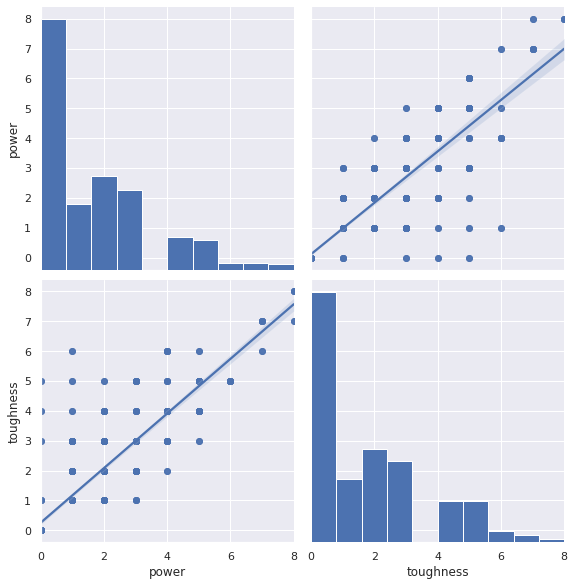

In [25]:
ax = sns.pairplot(pd_df, height=4, kind='reg')

In [26]:
# df_result.corr("power", "toughness", method="pearson")

In [27]:
pd_df.corr(method="spearman")

,power,toughness
power,1.000000,0.915025
toughness,0.915025,1.000000


In [28]:
df.agg({"toughness": "mean"}).collect()

[Row(avg(toughness)=2.93717277486911)]

In [29]:
df_result = df.agg(
    *[fn.min("power").alias("min"),
      fn.max("power").alias("max"),
      fn.format_number(fn.mean("power"), 2).alias("avg")
])
pd_df_power = df_result.toPandas().rename(index={0: 'power'})

In [30]:
df_result = df.agg(
    *[fn.min("toughness").alias("min"),
      fn.max("toughness").alias("max"),
      fn.format_number(fn.mean("toughness"), 2).alias("avg")
])
pd_df_toughness = df_result.toPandas().rename(index={0: 'toughness'})

In [31]:
pd.concat([pd_df_power, pd_df_toughness])

,min,max,avg
power,0,8,2.74
toughness,0,8,2.94


## Length of name 

In [32]:
df_result = df.selectExpr("name").select('name', fn.length("name").alias("length"))
pd_df = df_result.toPandas()

In [33]:
pd_df

,name,length
0,"Chandra, Awakened Inferno",25
1,"Chandra, Awakened Inferno",25
2,Cavalier of Flame,17
3,Cavalier of Thorns,18
4,Cavalier of Flame,17
...,...,...
653,Island,6
654,Hostile Minotaur,16
655,Imperial Outrider,17
656,Vorstclaw,9


In [34]:
df_result = df.selectExpr("name").\
    select("name", fn.split("name", "\s+").alias("tokens")).\
    select("name", "tokens", fn.size("tokens").alias("# tokens"))
pd_df = df_result.toPandas()

In [35]:
pd_df

,name,tokens,# tokens
0,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
1,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
2,Cavalier of Flame,"[Cavalier, of, Flame]",3
3,Cavalier of Thorns,"[Cavalier, of, Thorns]",3
4,Cavalier of Flame,"[Cavalier, of, Flame]",3
...,...,...,...
653,Island,[Island],1
654,Hostile Minotaur,"[Hostile, Minotaur]",2
655,Imperial Outrider,"[Imperial, Outrider]",2
656,Vorstclaw,[Vorstclaw],1


## Length of text 

In [36]:
df_result = df.selectExpr("name", "originalText").\
    select(fn.col("name").alias("card name"), fn.length("originalText").alias("length")).\
    orderBy(fn.desc("length"))
df_result = df_result.na.fill(value=0, subset=['length'])
pd_df = df_result.toPandas()

In [37]:
pd_df

,card name,length
0,"Ajani, Strength of the Pride",419
1,"Ajani, Strength of the Pride",419
2,"Chandra, Awakened Inferno",376
3,"Chandra, Awakened Inferno",376
4,"Chandra, Acolyte of Flame",367
...,...,...
653,Vorstclaw,0
654,Barony Vampire,0
655,Imperial Outrider,0
656,Vorstclaw,0


## Mana costs 

In [38]:
df_result = df.select(fn.col("name").alias("card name"),
                      fn.col("convertedManaCost").alias("converted mana cost")).\
                orderBy(fn.desc("converted mana cost"))
pd_df = df_result.toPandas()

In [39]:
pd_df

,card name,converted mana cost
0,"Vilis, Broker of Blood",8
1,"Vilis, Broker of Blood",8
2,"Sephara, Sky's Blade",7
3,"Drakuseth, Maw of Flames",7
4,"Sephara, Sky's Blade",7
...,...,...
653,Bloodfell Caves,0
654,Mountain,0
655,Island,0
656,Mountain,0


In [40]:
max_cmc = pd_df['converted mana cost'].max()

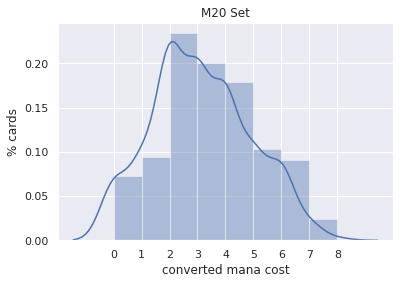

In [41]:
ax = sns.distplot(pd_df['converted mana cost'], bins=range(max_cmc + 1))
_ = ax.set_ylabel('% cards')
_ = ax.set_title('M20 Set')
_ = ax.set_xticks(range(max_cmc + 1))

# Groups 

## By color identity

In [42]:
df_result = df.groupby('colorIdentity').count()
pd_df = df_result.toPandas()

In [43]:
pd_df

,colorIdentity,count
0,"G,W",4
1,"G,R,U",2
2,"B,G,U",2
3,"B,G,W",2
4,"B,G,R,U,W",2
5,B,110
6,"R,W",6
7,"G,R,W",2
8,"G,R",4
9,U,100


In [44]:
df_result = df.groupby('colorIdentity').count().agg(
    fn.sum("count").alias("total number")
).collect()

In [45]:
print(df_result)

[Row(total number=658)]


## From Models, show encoded types

In [46]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [47]:
indexer = StringIndexer.load(f"{config.SPARK_MODELS}/stringindexer_str_types")
model = StringIndexerModel.load(f"{config.SPARK_MODELS}/stringindexer_model_str_types")

In [48]:
# model.stringOrderType

In [49]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [50]:
df.agg(
    *[fn.min(df.encodedTypes), fn.max(df.encodedTypes)]
).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                7|
+-----------------+-----------------+



## Make an overall histogram from encoded types. 

In [51]:
tmp = df.select("encodedTypes").rdd.flatMap(lambda x: x)

In [52]:
tmp.min(), tmp.max()

(0, 7)

In [53]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(8)

In [54]:
hist

([0.0, 0.875, 1.75, 2.625, 3.5, 4.375, 5.25, 6.125, 7],
 [34, 20, 362, 42, 74, 48, 24, 54])

In [55]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [56]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

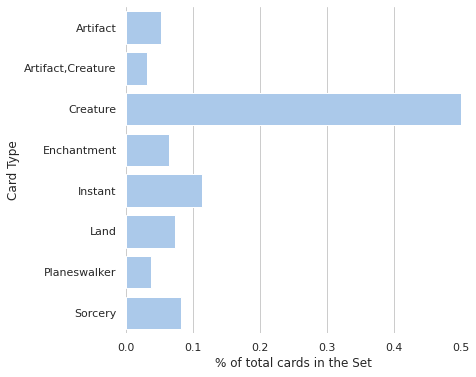

In [57]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

# ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
ax.set(xlim=(0, 0.5), xlabel="% of total cards in the Set", ylabel="Card Type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

## By color identity and encoded type

First, let's fetch the distinct color identities

In [58]:
pd_colorIdentities  = df.select("colorIdentity").alias("Color_Identity").distinct().sort("colorIdentity").toPandas()

In [59]:
pd_colorIdentities

,colorIdentity
0,
1,B
2,"B,G"
3,"B,G,R,U,W"
4,"B,G,U"
5,"B,G,W"
6,"B,R"
7,"B,R,W"
8,"B,U"
9,"B,W"


In [60]:
pd_encodedTypes = pd.DataFrame(np.arange(8), columns=['Encoded_Types'])

In [61]:
pd_encodedTypes

,Encoded_Types
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


Create a cartesian product of the color identities and the encoded types.

In [62]:
pd_colorIdentities['key'] = 0
pd_encodedTypes['key'] = 0

In [63]:
pd_cartesian = pd_colorIdentities.merge(pd_encodedTypes, how='outer').drop(columns=['key'])

In [64]:
pd_cartesian = pd_cartesian.rename(columns={'colorIdentity':'Color_Identity'})

In [65]:
pd_cartesian

,Color_Identity,Encoded_Types
0,,0
1,,1
2,,2
3,,3
4,,4
...,...,...
179,W,3
180,W,4
181,W,5
182,W,6


Now, let's create a list which will hold the following: ((color identity, encoded type), 1).

In [66]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('R', 6), 1),
 (('R', 6), 1),
 (('R', 2), 1),
 (('G', 2), 1),
 (('R', 2), 1),
 (('G,R,U', 2), 1),
 (('R', 0), 1),
 (('G', 2), 1),
 (('B,R,W', 2), 1),
 (('U', 2), 1)]

Finally, let's compute the sum of the number of a found encoded types per color identity.

In [67]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey()

In [68]:
map2.take(5)

[(('', 0), 22), (('', 1), 18), (('', 5), 8), (('B', 0), 2), (('B', 2), 66)]

For convience, let's break down the (color identity, encoded type) key into a list of: (color identity, encoded type, sum). 

In [69]:
map3 = map2.map(lambda x: (x[0][0], x[0][1], x[1]))

In [70]:
pd_tab = map3.toDF().toPandas()

In [71]:
pd_tab.columns = ['Color_Identity', 'Encoded_Types', 'Total']

In [72]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total
0,,0,22
1,,1,18
2,,5,8
3,B,0,2
4,B,2,66


Based on the color identity and encoded types, assign a key that corresponds to the cartesian product.

In [73]:
def assign_index(row):
    filter1 = pd_cartesian['Color_Identity'] ==  row['Color_Identity']
    filter2 = pd_cartesian['Encoded_Types'] == row['Encoded_Types']
    
    idx = pd_cartesian.index[filter1 & filter2].tolist()[0]

    return idx

In [74]:
pd_tab['Cart_Index'] = pd_tab.apply (lambda row: assign_index(row), axis=1)

In [75]:
# pd_tab.max()

In [76]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total,Cart_Index
0,,0,22,0
1,,1,18,1
2,,5,8,5
3,B,0,2,8
4,B,2,66,10


Find the missing indexes from the cartesian product, and fill-in with "total = 0".

In [77]:
missing_cart_indexes = set(pd_cartesian.index.tolist()) - set(pd_tab.Cart_Index.tolist())

In [78]:
for index in missing_cart_indexes:
    row = pd_cartesian.iloc[index]

    new_df = row.copy()
    new_df['Total'] = 0
    new_df['Cart_Index'] = index
    
    pd_tab = pd_tab.append(new_df)

In [79]:
group_result = pd_tab.groupby('Encoded_Types')

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


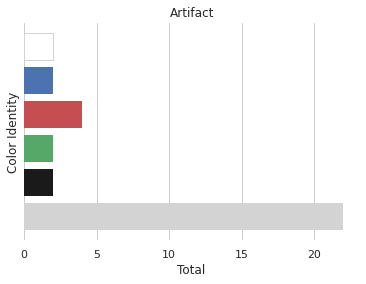

In [80]:
for group_id, (name, indices) in enumerate(group_result.indices.items()):
    group = pd_tab.iloc[indices]
    group.fillna(0)
    
#     print(group)

    f_group = group[group['Total'] > 0]

    labels = f_group['Color_Identity']
    totals = f_group['Total']

    sns.set(style="whitegrid")
    # sns.set()
    sns.set_palette("pastel")

    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        plt.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")

    plt.title(model.labels[group_id])
    plt.xlabel('Total')  
    plt.ylabel('Color Identity')
#     plt.yticks(range(6), labels)
    plt.yticks([])
    sns.despine(left=True, bottom=True)

    plt.show()  
    
    break

### Bars with Gradients

In [81]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def gradientbars(bars, color):
    grad = np.atleast_2d(np.linspace(0,1,256))
    rgb0 = matplotlib.colors.to_rgba('w')
    rgb1 = matplotlib.colors.to_rgba(color)
    cmap = LinearSegmentedColormap.from_list('tmp', (rgb0, rgb1))

    
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x+w, y, y+h], cmap=cmap,aspect="auto", zorder=0)

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


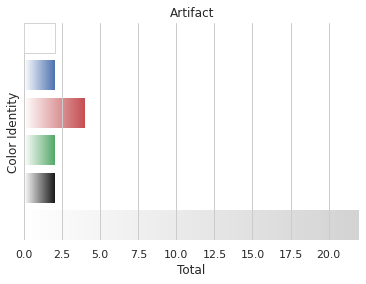

In [82]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set_palette("pastel")


with sns.color_palette("pastel"):
    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    fig, ax = plt.subplots()

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        bar = ax.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")
        
        gradientbars(bar, color)

    ax.set_title(model.labels[group_id])
    ax.set_xlabel('Total')  
    ax.set_ylabel('Color Identity')
    #     plt.yticks(range(6), labels)
    ax.set_yticks([])
    ax.axis('auto')
    sns.despine(left=True, bottom=True)

    plt.show()  

### Bars with Gradient and Symbols

In [83]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [84]:
sns.set()

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


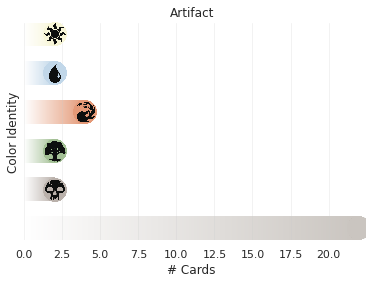

In [85]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set(style="whitegrid")
# sns.set()
sns.set_palette("pastel")

colors = {
    '': '#cac5c0ff',
    'W': '#f8f6d8ff',
    'U': '#c1d7e9ff',
    'B': '#bab1abff',
    'R': '#e49977ff',
    'G': '#a3c095ff'
}

edge_colors = {
    '': '',
    'W': '',
    'U': '',
    'B': '',
    'R': '',
    'G': ''
}

images = {
    '': '../assets/Mana/C.png',
    'W': '../assets/Mana/W.png',
    'U': '../assets/Mana/U.png',
    'B': '../assets/Mana/B.png',
    'R': '../assets/Mana/R.png',
    'G': '../assets/Mana/G.png'
}

fig, ax = plt.subplots()

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    color = colors[label]
    ecolor = ''
    image = images[label]
    bar = plt.barh(i, val, color=color, height=0.60, linewidth=0.0, alpha=1.0, edgecolor=ecolor)#, hatch='/')
    
    ab = AnnotationBbox(OffsetImage(plt.imread(image), zoom=0.075), (val, i), frameon=False)
    ax.add_artist(ab)
    
    gradientbars(bar, color)

plt.title(model.labels[group_id])
plt.xlabel('# Cards')  
plt.ylabel('Color Identity')
plt.yticks([])
plt.grid(linewidth=1.0, alpha=0.25)
sns.despine(left=True, bottom=True)
plt.axis('auto')


plt.show()  

###  Cummulative Bar

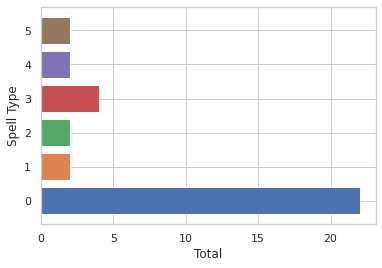

In [86]:
sns.set(style="whitegrid")

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    
    plt.barh(i, val)
#     prev = prev + val

plt.xlabel('Total')  
plt.ylabel('Spell Type')

plt.show()  